### Imports and data loading

In [320]:
import pandas as pd
import backtrader as bt
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt

# Load the data into a Pandas DataFrame

# Set the path to the root directory
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)

# Load Model 3 prediction file
df = pd.read_csv(path + '/data/predictions/12.csv')

### Data processing

In [321]:
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'], unit='D')
df = df.dropna()

In [322]:
# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

# Adding intrinsic value as Price on expirty date
# Iterate over every option, which is identified by the combination of Quote_date, Expiry_date, Strike
groups = df.groupby(['Expiry_date', 'Strike'])
for _, group in groups:
    # Create a new row for the date of expiry
    new_row = group.iloc[-1].copy()
    new_row['Price'] = max(0, new_row['Underlying_last'] - new_row['Strike'])
    new_row['TTM'] = 0
    new_row['Quote_date'] = new_row['Expiry_date']
    df = pd.concat([df, new_row.to_frame().transpose()], ignore_index=True)


# Quote_date and Expiry_date to datetime
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

df_read = df.copy()


### Parameters

In [323]:
buy_threshold = 10
sell_threshold = 10
starting_balance = 1000000

### Functions

In [334]:
def generate_buy_signals(df, buy_threshold):
    buy_signal = (df['Prediction'] - df['Price']) >= buy_threshold
    return buy_signal

def trader(df, buy_signal, starting_balance):
    # Data
    last_date = df['Quote_date'].max()
    df = df[df['Expiry_date'] < last_date]
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df['Balance'] = starting_balance
    df["Position_this_opt"] = 0

    # Iterate over every group of options, which is identified by the combination of Expiry_date, Strike
    groups = df.groupby(['Expiry_date', 'Strike'])
    for _, group in groups:
        option_bought = False
        # Iterate over every row in the group
        for index, row in group.iterrows():
            
            # If the signal is 1, then buy the option
            # Also, check if the balance is greater than the price of the option for this row and all rows after this row in the entire DataFrame
            if row['Signal'] == 1 and option_bought == False and row['Balance'] >= row['Price'] and df["Balance"].iloc[index:].min() >= row["Price"]:
                option_bought = True
                # Position handeling
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Expiry_date'] == row['Expiry_date']) & (df['Strike'] == row['Strike']), 'Position_this_opt'] = 1
                # Balance handeling
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] - row['Price']


            # Option expires, recive the intrinsic value
            if row["Quote_date"] == row["Expiry_date"] and option_bought == True:
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                # Add the price of the option to the balance in every row including and after this Quote_date
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] + intrinsic_value        
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value column
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    return df


### Run code

In [335]:
df = df_read.copy()
df = df[df['Quote_date'] <= "2018-06-27"]
buy_signal = generate_buy_signals(df, buy_threshold)
df = trader(df, buy_signal, starting_balance)
df = calculate_options_value(df)

print("Starting balance", starting_balance)
print("Ending balance", df['Balance'].iloc[-1])

/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_6348/2690333976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = 0
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_6348/2690333976.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Balance'] = starting_balance
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_6348/2690333976.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Starting balance 1000000
Ending balance 1098580.445000031


In [336]:
# Just keep one row per Quote_date, and that should be the last row
df = df.groupby('Quote_date').last()

In [337]:
display(df)

,Unnamed: 0,Price,Prediction,Underlying_last,Strike,TTM,R,Expiry_date,Signal,Balance,Position_this_opt,Options_value
Quote_date,,,,,,,,,,,,
2017-12-22,3138484,0.250,0.0,2683.72,3300.0,175,1.54,2018-06-15,0,999983.450,0,16.550
2017-12-26,3135037,0.000,0.0,2683.72,3000.0,0,1.15,2017-12-26,0,999985.585,0,22.745
2017-12-27,3139180,0.000,0.0,2680.42,3000.0,0,1.24,2017-12-27,0,999991.425,0,5.840
2017-12-28,3150410,0.275,0.0,2687.17,3300.0,169,1.54,2018-06-15,0,999957.880,0,33.545
2017-12-29,3147211,0.000,0.0,2687.17,3100.0,0,1.19,2017-12-29,0,999958.745,0,20.670
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-15,3246760,0.000,0.0,2821.66,3500.0,0,1.48,2018-06-15,0,1098580.445,0,96600.080
2018-06-18,3650355,0.000,0.0,2749.21,3100.0,0,1.82,2018-06-18,0,1098580.445,0,0.000
2018-06-20,3650482,0.000,0.0,2749.21,3100.0,0,1.82,2018-06-20,0,1098580.445,0,0.000


NameError: name 'plt' is not defined

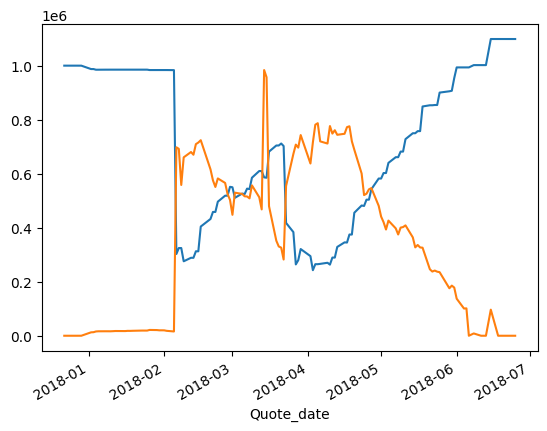

In [346]:
# Plot the balance over time before 2018-03-01
df['Balance'].plot()

# Plot the options value over time
df['Options_value'].plot()

# Add labels
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Balance over time')

# Add legend
plt.legend()

In [343]:
# New column total value
df['Total_value'] = df['Balance'] + df['Options_value']

print("Max total value", df['Total_value'].max(), "Min total value", df['Total_value'].min())

Max total value 1570106.4350000075 Min total value 882988.2250000006


<AxesSubplot: xlabel='Quote_date'>

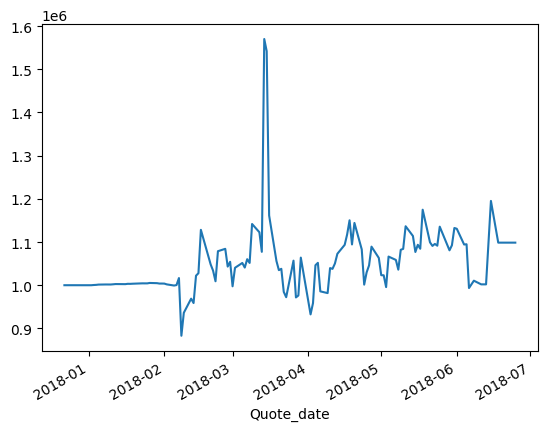

In [344]:
# Plot total value
df["Total_value"].plot()

In [345]:
# Calculate sharpe ratio
daily_returns = df['Total_value'].pct_change()
sharpe_ratio = daily_returns.mean() / daily_returns.std()
print("Sharpe ratio", sharpe_ratio)

Sharpe ratio 0.04192168844164293
